# Imports

In [1]:
import os.path
from os.path import isfile, join
import os
from os import listdir
from osgeo import gdal
import errno
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds #Window
from rasterio.enums import Resampling
from sys import platform

In [4]:
if platform == "linux" or platform == "linux2":
    path_satellite = "/home/jovyan/work/satellite_data/"
    path_labels = os.getcwd() + "/1_labeled_data/tif/"
    cutouts_path = os.getcwd() + "/2_cutouts/"
elif platform == "darwin":
    path_data = "/Users/leori/Desktop/BA/1_Data/"
    path_satellite = path_data + "2_satellite/"
    path_labels = path_data + "1_labeled_data/tif/"
    cutouts_path = None
elif platform == "win32":
    print("Something went wrong")

# Data Inspection

In [ ]:
# inspect_tif from 15.02.2022
# General Dataset Information
def inspect_tif(dataset):
    # print("1. General TIF Data:")
    # print("Metadata:", dataset.GetMetadata())
    # print("Type Image: ", type(dataset))
    # print("Projection: ", dataset.GetProjection())
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
    # print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
    #                         dataset.GetDriver().LongName))
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Raster Band
    band = dataset.GetRasterBand(1)
    # print("2. Raster Band:")
    # print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(int(min),int(max)))

    # if band.GetOverviewCount() > 0:
    #     print("Band has {} overviews".format(band.GetOverviewCount()))

    # if band.GetRasterColorTable():
    #     print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))
        
    size_x_px = dataset.RasterXSize
    size_y_px = dataset.RasterYSize
    pixel_size = (dataset.GetGeoTransform()[1], dataset.GetGeoTransform()[5])
    size_x = size_x_px * pixel_size[0]
    size_y = size_y_px * pixel_size[1]
    print("# Pixels in Image = ({}, {}) with a Raster Count of {}".format(size_x_px, size_y_px, dataset.RasterCount))
    print("Size of one Pixel in cm = {}".format(tuple([100000*x for x in pixel_size])))
    print("Size Covered by Image / Image Size = ({}m, {}m)".format(round(1000*size_x, 2), abs(round(1000*size_y, 2))))

    # band1 = labels.GetRasterBand(1) # Red channel
    # band2 = labels.GetRasterBand(2) # Green channel
    # band3 = labels.GetRasterBand(3) # Blue channel
    #labels.GetRasterBand()

# inspect_tif(dataset)

# Cutouts

In [2]:
def load_tif(files_list: list = None, is_label: bool = False, cutout_window: tuple = None):
    if cutout_window: load_tif.cutout_window = cutout_window
    # loop through array of file names
    for filename in files_list:
        complete_filepath = (path_labels if is_label else path_satellite) + filename
        # check if filepath exists
        if not os.path.isfile(complete_filepath):
            print("Filepath does not exist: {}".format(complete_filepath)) 
            continue
        # open file
        label_file = gdal.Open(complete_filepath)
        # check if gdal is able to open file
        if label_file:
            # print(f"{bcolors.OKBLUE}{filename}{bcolors.ENDC}")
            print(f"{bcolors.OKGREEN}0 Success: {bcolors.ENDC}{bcolors.OKBLUE}{filename}{bcolors.ENDC}") 
            inspect_tif(label_file)
            # if is_label:
            print(f"{bcolors.UNDERLINE}Cutouts:{bcolors.ENDC}")
            # create cutouts
            create_cutouts(filename, label_file, cutout_window)
            continue
        print(f"{bcolors.FAIL}1 Failure:{bcolors.ENDC}" + complete_filepath) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

In [3]:
def create_cutouts(path_label: list = None, label_file: list = None, cutout_window: tuple = None):
    #print("load_tif.cutout_window:", load_tif.cutout_window)
    # upper/lower (u/l) left/right (l/r) coordinates 
    ulx, xres, xskew, uly, yskew, yres  = label_file.GetGeoTransform()
    width, height = label_file.RasterXSize, label_file.RasterYSize
    lrx = ulx + width * xres
    lry = uly + height * yres # Vorzeichen von Koordinaten wichtig (!)
    
    # Label and satellite image do not have the same origin. So it has to be standardized/adjusted.
    # If it is a satellite image, the cutout_window is not passed. Hence, it is set
    # If it is a label, the cutout_window is copied from the satellite image
    if (cutout_window == None): load_tif.cutout_window = (ulx, uly, lrx, lry)
    # TODO BEI LABELS WIRD DAS AUCH AUSGEFÜHRT, WEIL CUTOUT-WINDOW NICHT EXISTIERT
    else: ulx, uly, lrx, lry = cutout_window[0], cutout_window[1], cutout_window[2], cutout_window[3]
    print("Übergebenes cutout_window:", cutout_window)
    #print("load_tif.cutout_window:", load_tif.cutout_window)
    # corner & cener coordinates can be checked in the terminal with 
    # $ gdalinfo '/home/jovyan/work/satellite_data/FILE.tif'
    # determine cutout window of size: 512x512 px
    cutout_size = 512 * 2 # patch_size in paper = 256 (with 0,5m res/pixel) || 512 geht auch fit
    
    no_of_x_cutouts = 2 #int(width / cutout_size)
    no_of_y_cutouts = 2 #int(height / cutout_size)
    
    for cutout_y in range(no_of_y_cutouts):
        for cutout_x in range(no_of_y_cutouts):
            if cutout_window == None:
                # ul_corner = (ulx, uly)
                # lr_corner = (lrx, lry)
                # base value (upper left corner of image + how far the cutout is moved in each iteration
                crop_ulx = ulx + (cutout_x * cutout_size * xres)
                crop_uly = uly + (cutout_y * cutout_size * yres)
                # base value (upper left corner of defined cutout) + cutout size (converted in coordinates with resolution)
                crop_lrx = crop_ulx + cutout_size * xres
                crop_lry = crop_uly + cutout_size * yres
                
                cropped_window = (crop_ulx,crop_uly,crop_lrx,crop_lry)
            else: cropped_window = cutout_window
                
            print(f"{bcolors.OKBLUE}Cropped Window: {cropped_window}{bcolors.ENDC}")
            # export cropped raster
            cutout_filename = path_label.replace(".tif", "") + "-{}-{}.tif".format(cutout_x, cutout_y)
            cutout_path = cutouts_path + cutout_filename
            # print(f"Cutout: {bcolors.OKBLUE}{cutout_path}{bcolors.ENDC}")
            gdal.Translate(cutout_path, label_file, projWin = cropped_window) #label_file is the tif file

            # set the cutout window for the next iteration and for the labels
            load_tif.cutout_window = cropped_window
            
            # preview tif
            #load_tif([cutout_path])
            cutout = gdal.Open(cutout_path)
            # check if gdal is able to open file
            if cutout:
                print(f"{bcolors.OKGREEN}0 Success: {cutout_filename}{bcolors.ENDC}") # complete path: cutout_path
                inspect_tif(cutout)
            preview_tif(cutout_path)
    # close tif
    cutout_path = label_file = cropped_window = None

In [ ]:
def compare_satellite_label(satellite, label):
    # file =  rasterio.open(complete_filepath)
    filepath_satellite, filepath_label = path_satellite + satellite, path_labels + label
    # check if filepath exists
    if not os.path.isfile(filepath_satellite) or not os.path.isfile(filepath_label):
        print(f"{bcolors.FAIL}1 Failure: File(s) do(es) not exist: {complete_filepath}{bcolors.ENDC}") 
        return
    
    src_label = rasterio.open(filepath_label)
    
    src_satellite = rasterio.open(filepath_satellite)
    left, top = src_satellite.bounds[0], src_satellite.bounds[3]
    # get edge coordinates of tif
    # left, bottom, right, top = src_satellite.bounds[0], src_satellite.bounds[1], src_satellite.bounds[2], src_satellite.bounds[3]
    # print("coord:",left, bottom, right, top)
    # print("type",type(src.read(1))) # <class 'numpy.ndarray'>
    # print(src.meta)
    # print("Shape:", file.shape)
    # print("Width: {}, Height: {}".format(src.width, src.height))
    patch_size = 512
    overlap = 32 # similar to previous project: 0.12 * 256 = 30.72
    xRes, yRes = src_satellite.res # or: src.meta['transform'][0], -src.meta['transform'][4]
    right  = left + patch_size * xRes
    bottom = top  - patch_size * yRes
    # print("coord:",left, bottom, right, top)
    # print("Resolution: {} x {}".format(xRes, yRes))
    # print("#Attributs:", src_satellite.count)
    # print("Georeferecing:", src_satellite.bounds)
    # print("transform:", src_satellite.transform)

    x_cutout_max, y_cutout_max = int(src_satellite.width / patch_size), int(src_satellite.height / patch_size)
    # print("max cutout:", x_cutout_max, y_cutout_max)

    x_cutout_max, y_cutout_max = 2, 3 #tmp(!)

    for y_cutout in range(y_cutout_max):
        for x_cutout in range(x_cutout_max):
            print("Cutout Window: ({}, {}, {}, {})".format(left, top, right, bottom))
            # print("Size of cutout window in px: {} x {}".format((right - left) / xRes, (top - bottom) / yRes))
            cutout_satellite = src_satellite.read(1, window = from_bounds(left, bottom, right, top, src_satellite.transform))
            cutout_label = src_label.read(1, window = from_bounds(left, bottom, right, top, src_label.transform))
            
            # show(cutout_satellite)
            # show(cutout_label)
            
            # adjust cutout window for next iteration (with 30 px overlap to cover trees on the edge)
            # adjust cutout window on the x-axis => move cutout window to the right - the overlap
            left = right - overlap * xRes # use right as a base and move left by the overlap  
            right  = left + patch_size * xRes # move patch_size to the right from left # += patch_size * xRes
        # reset the x-axis
        left = src_satellite.bounds[0]
        right  = left + patch_size * xRes
        # adjust cutout window on the y-axis => move cutout window to the bottom
        top = bottom - overlap * yRes
        bottom = top - patch_size * yRes # -= patch_size * yRes

    src_satellite.close()
    src_label.close()

## Cutouts With Coordinates

In [ ]:
window = (29.746877767434313, -26.247113163017453, 29.76293355949657, -26.26316895507971)

# Model

## Extra Layers for Model for 512 px

In [ ]:
"""# change so that it uses 512 px img instead of 256
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

def UNet(input_shape, input_label_channel, layer_count=64, regularizers = regularizers.l2(0.0001), gaussian_noise=0.1, weight_file = None):
        """ Method to declare the UNet model.

        Args:
            input_shape: tuple(int, int, int, int)
                Shape of the input in the format (batch, height, width, channels).
            input_label_channel: list([int])
                list of index of label channels, used for calculating the number of channels in model output.
            layer_count: (int, optional)
                Count of kernels in first layer. Number of kernels in other layers grows with a fixed factor.
            regularizers: keras.regularizers
                regularizers to use in each layer.
            weight_file: str
                path to the weight file.
        """

        input_img = layers.Input(input_shape[1:], name='Input')
        pp_in_layer  = input_img
#        pp_in_layer = layers.GaussianNoise(gaussian_noise)(input_img)
#        pp_in_layer = layers.BatchNormalization()(pp_in_layer)


        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(pp_in_layer)
        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c1)
        n1 = layers.BatchNormalization()(c1)
        p1 = layers.MaxPooling2D((2, 2))(n1)

        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c2)
        n2 = layers.BatchNormalization()(c2)
        p2 = layers.MaxPooling2D((2, 2))(n2)

        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c3)
        n3 = layers.BatchNormalization()(c3)
        p3 = layers.MaxPooling2D((2, 2))(n3)

        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c4)
        n4 = layers.BatchNormalization()(c4)
        p4 = layers.MaxPooling2D(pool_size=(2, 2))(n4)
        
        # Added start 1/2
        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(p4)
        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(c5)
        n5 = layers.BatchNormalization()(c5)
        p5 = layers.MaxPooling2D(pool_size=(2, 2))(n5)
        # Added end 1/2

        c6 = layers.Conv2D(32*layer_count, (3, 3), activation='relu', padding='same')(p5)
        c6 = layers.Conv2D(32*layer_count, (3, 3), activation='relu', padding='same')(c6)
        
        u6 = layers.UpSampling2D((2, 2))(c5) # upsampling layers not renamed. Id could be increased by 1
        n6 = layers.BatchNormalization()(u6)
        u6 = layers.concatenate([n6, n5])
        c7 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(u6)
        c7 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(c7)

        u7 = layers.UpSampling2D((2, 2))(c7)
        n7 = layers.BatchNormalization()(u7)
        u7 = layers.concatenate([n7, n4])
        c8 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(u7)
        c8 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c7)

        u8 = layers.UpSampling2D((2, 2))(c8)
        n8 = layers.BatchNormalization()(u8)
        u8 = layers.concatenate([n8, n3])
        c9 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(u8)
        c9 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c9)

        u9 = layers.UpSampling2D((2, 2))(c8)
        n9 = layers.BatchNormalization()(u9)
        u9 = layers.concatenate([n9, n2], axis=3)
        c10 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(u9)
        c10 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c10)

        # Added start 2/2
        u10 = layers.UpSampling2D((2, 2))(c9)
        n10 = layers.BatchNormalization()(u10)
        u10 = layers.concatenate([n10, n1], axis=3)
        c11 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(u10)
        c11 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c11)
        # Added end 2/2
        d = layers.Conv2D(len(input_label_channel), (1, 1), activation='sigmoid', kernel_regularizer= regularizers)(c10)

        seg_model = models.Model(inputs=[input_img], outputs=[d])
        if weight_file:
            seg_model.load_weights(weight_file)
        seg_model.summary()
        return seg_model"""

In [ ]:
def calc_coord_lr(filepath, coord_w, coord_n):
    src_img = rasterio.open(filepath)
    xRes, yRes = src_img.res
    # print(xRes, yRes)
    coord_s = coord_n  - config.patch_size[0] * yRes
    coord_e  = coord_w + config.patch_size[1] * xRes 

    cut_win = (coord_w, coord_s, coord_e, coord_n)
    return cut_win

In [ ]:
x = 512
# coordinates: left, bottom, right, top
# c_w, c_s, c_e, c_n = 29.748021463931796, -26.249614109300325, 29.74923634485858, -26.24839922837354
# c_w, c_s, c_e, c_n = 29.747940788245252, -26.249690039358253, 29.748548228708646, -26.24908259889486
# c_w, c_s, c_e, c_n = 29.748021463931796, -26.249006668836934, 29.74862890439519, -26.24839922837354

In [ ]:
def check_bounds(opened_raster, checked_c_w, checked_c_s, checked_c_e, checked_c_n, ):
    c_w, c_e = opened_raster.bounds[0], opened_raster.bounds[2]
    c_n, c_s = opened_raster.bounds[1], opened_raster.bounds[3]
    print("Bounds:", c_w, c_s, c_e, c_n)
    if checked_c_w < c_w: print(f"{colors.FAIL}The coordinates are too far west ({checked_c_w}). Increase it between {c_w} and {c_e}{colors.ENDC}")
    if checked_c_e > c_e: print(f"{colors.FAIL}The coordinates are too far east ({checked_c_e}). Decrease it between {c_w} and {c_e}{colors.ENDC}")
    if checked_c_n < c_n: print(f"{colors.FAIL}The coordinates are too far north ({checked_c_n}). Decrease it between {c_s} and {c_n}{colors.ENDC}")
    if checked_c_s > c_s: print(f"{colors.FAIL}The coordinates are too far south ({checked_c_s}). Increase it between {c_s} and {c_n}{colors.ENDC}")

In [ ]:
# reset to bounds
c_w, c_n = 29.7481, -26.25

Bounds: 29.746877767434313 -26.247113163017453 30.003673223333696 -26.502897800020722
29.7481 -26.250607440463394 29.748707440463395 -26.25
Shape: (3, 256, 256)


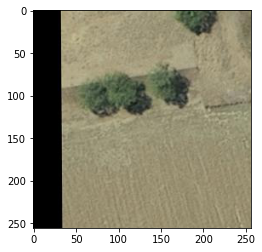

<AxesSubplot:>

In [ ]:
sat_lr = calc_coord_lr(config.filepath_satellite, c_w, c_n)
src_satellite = rasterio.open(config.filepath_satellite)
check_bounds(src_satellite, sat_lr[0], sat_lr[1], sat_lr[2], sat_lr[3])
cutout_satellite = src_satellite.read(None, 
    window = from_bounds(c_w, sat_lr[1], sat_lr[2], c_n, src_satellite.transform))
    # window = from_bounds(29.747940788245252, -26.247720603480847, 29.748548228708646, -26.247113163017453, src_satellite.transform))
print(c_w, sat_lr[1], sat_lr[2], c_n)
print("Shape:", cutout_satellite.shape)
show(cutout_satellite)

29.7481 -26.250607440463384 29.748707440463633 -26.25
Shape: (256, 256)


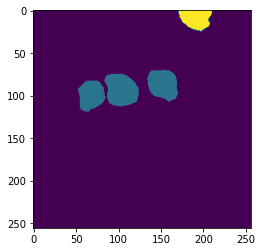

<AxesSubplot:>

In [ ]:
src_label = rasterio.open(config.filepath_label)
lab_lr = calc_coord_lr(config.filepath_label, c_w, c_n)
cutout_label = src_label.read(1, 
    window = from_bounds(c_w, lab_lr[1] - 0.0000001, lab_lr[2], c_n, src_label.transform)) 
    # TODO: Had to adjust bottom coordinate, beccause it always rounded the coordinates in a way that the shape was (255,256)
    # window = from_bounds(29.747940788245252, lab_lr[1], lab_lr[2], -26.247113163017453, src_label.transform))
print(c_w, lab_lr[1], lab_lr[2], c_n)
print("Shape:", cutout_label.shape)
show(cutout_label)

In [ ]:
cutout_satellite.shape
cutout_label.shape

(3, 255, 256)

(256, 256)